In [3]:
from pathlib import Path
import pickle

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import dataretrieval.nwis as nwis

In [4]:
def get_nwis_data(sites: list[str], start: pd.Timestamp, end: pd.Timestamp) -> pd.DataFrame:
    """
    Query NWIS service to get site records
    """

    # Parse dates to strings for NWIS
    str_start = start.strftime(r"%Y-%m-%d")
    str_end = end.strftime(r"%Y-%m-%d")

    # get site information
    site_info, md = nwis.get_info(sites=sites)

    # get daily values (dv)
    df_daily = nwis.get_record(service="dv", sites=sites, start=str_start, end=str_end)

    # get instantaneous values (iv)
    df_iv = nwis.get_record(service="iv", sites=sites, start=str_start, end=str_end)

    # get parameter descriptions
    parameter_codes = list(
        set([col.partition("_")[0] for col in df_daily.columns if col[0].isdigit()])
    )

    df_parameter_descriptions = nwis.get_record(parameterCd=parameter_codes, service="pmcodes")

    return {
        "df_daily": df_daily,
        "df_instantaneous": df_iv,
        "site_info": site_info,
        "parameter_codes": df_parameter_descriptions,
    }

In [5]:
sites = [
    "413548087395901",  # RAIN GAGE AT CALUMET UNION DR CANAL NR MARKHAM, IL
    "413516087442101",  # RAIN GAGE AT OAK FOREST, IL
    "413510087380201",  # RAIN GAGE AT HARVEY, IL
    "414028087383501",  # RAIN GAGE AT WEST PULLMAN AT CHICAGO, IL
    "414030087450001",  # RAIN GAGE AT ALSIP, IL
    "413104087440001",  # RAIN GAGE AT MATTESON, IL
    "415755087525300",  # OHARE AIRPORT AT CHICAGO, IL
]

start = pd.Timestamp("2021-04-01 00:00:00")
end = pd.Timestamp("2021-11-01 00:00:00")

In [6]:
# target folder
target_path = Path("usgs")
target_path.mkdir(exist_ok=True)

if (data_path := target_path / "usgs_data.pkl").exists():
    with open(data_path, "rb") as f:
        data = pickle.load(f)

else:
    data = get_nwis_data(sites=sites, start=start, end=end)
    with open(data_path, "wb") as f:
        pickle.dump(data, f)

daily, df, site_info, pcodes = data.values()

In [7]:
daily.head()

00020_Maximum 00020_Maximum_cd  \
site_no         datetime                                                    
413104087440001 2021-04-01 00:00:00+00:00           11.0                A   
                2021-04-02 00:00:00+00:00           15.2                A   
                2021-04-03 00:00:00+00:00           24.4                A   
                2021-04-04 00:00:00+00:00           29.3                A   
                2021-04-05 00:00:00+00:00           28.5                A   

                                           00020_Minimum 00020_Minimum_cd  \
site_no         datetime                                                    
413104087440001 2021-04-01 00:00:00+00:00           -3.4                A   
                2021-04-02 00:00:00+00:00           -6.4                A   
                2021-04-03 00:00:00+00:00            3.1                A   
                2021-04-04 00:00:00+00:00            4.0                A   
                2021-04-05 00:00:00+00:00           14.4                A   

                                           00020_Mean 00020_Mean_cd  \
site_no         datetime                                              
413104087440001 2021-04-01 00:00:00+00:00         2.7             A   
                2021-04-02 00:00:00+00:00         5.1             A   
                2021-04-03 00:00:00+00:00        13.0             A   
                2021-04-04 00:00:00+00:00        17.5             A   
                2021-04-05 00:00:00+00:00        20.1             A   

                                           00045_Sum 00045_Sum_cd  
site_no         datetime                                           
413104087440001 2021-04-01 00:00:00+00:00        0.0            A  
                2021-04-02 00:00:00+00:00        0.0            A  
                2021-04-03 00:00:00+00:00        0.0            A  
                2021-04-04 00:00:00+00:00        0.0            A  
                2021-04-05 00:00:00+00:00        0.0            A

/tmp/ipykernel_63156/3962143307.py:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


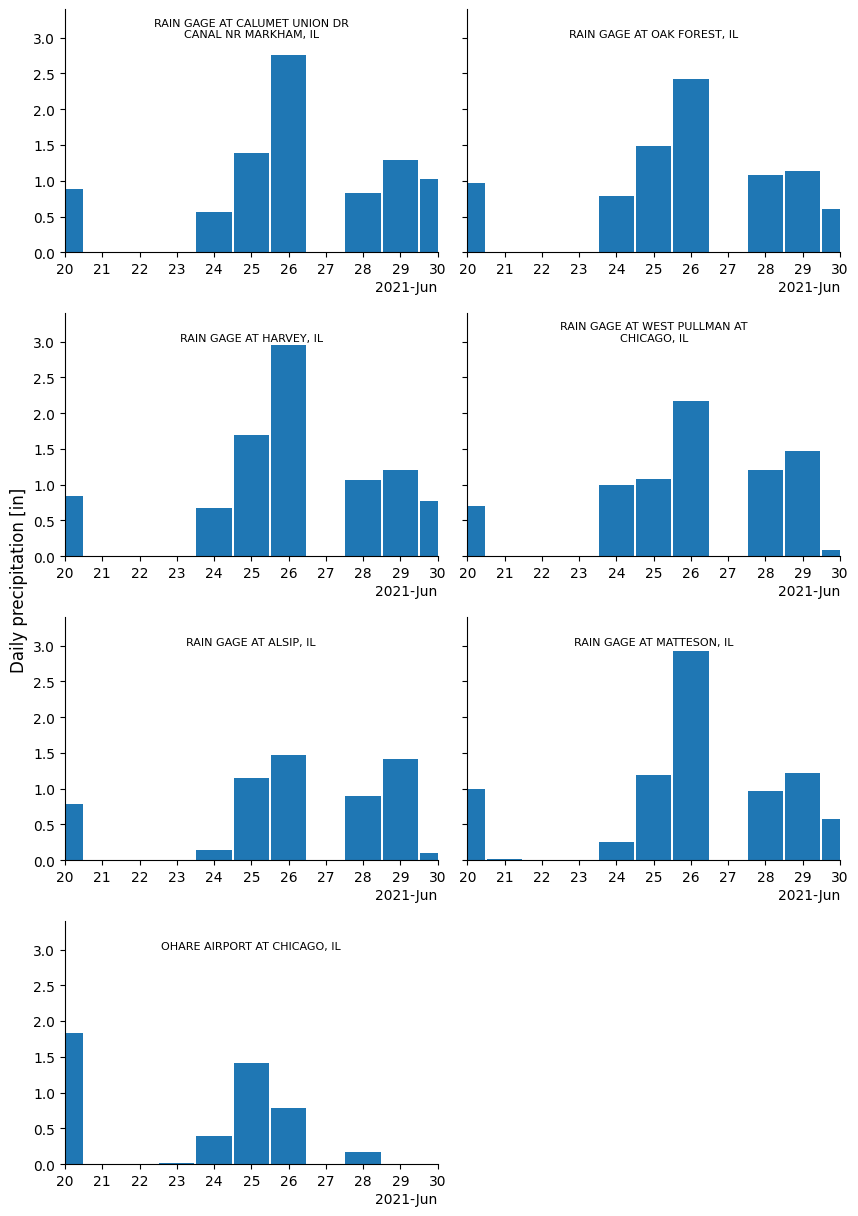

In [8]:
from math import ceil
from textwrap import wrap

fig, axs = plt.subplots(
    4,
    ceil(len(sites) / 4),
    sharey=True,
    figsize=(10, 15),
    gridspec_kw={"hspace": 0.25, "wspace": 0.08},
)

for ax, site in zip(axs.flatten(), sites):
    subdf = daily.xs(site)["00045_Sum"]
    ax.bar(subdf.index, subdf, width=pd.Timedelta("0.95d"))
    title = site_info.set_index("site_no").loc[site]["station_nm"]
    wrapped_title = "\n".join(wrap(title, width=30))
    ax.set_title(wrapped_title, fontsize=8, y=0.85)
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)

    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    ax.set_xlim(pd.Timestamp("2021-06-20"), pd.Timestamp("2021-06-30"))

ax.set_ylim(0, 3.4)
fig.supylabel("Daily precipitation [in]", x=0.07)

for ax in axs.flatten()[len(sites) :]:
    ax.remove()

fig.tight_layout()
plt.show()

In [9]:
site_info

,agency_cd,site_no,station_nm,site_tp_cd,lat_va,long_va,dec_lat_va,dec_long_va,coord_meth_cd,coord_acy_cd,...,reliability_cd,gw_file_cd,nat_aqfr_cd,aqfr_cd,aqfr_type_cd,well_depth_va,hole_depth_va,depth_src_cd,project_no,geometry
0,USGS,413104087440001,"RAIN GAGE AT MATTESON, IL",AT,413104,874400,41.517778,-87.733333,N,S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CAWS0,POINT (-87.73333 41.51778)
1,USGS,413510087380201,"RAIN GAGE AT HARVEY, IL",AT,413510,873802,41.586111,-87.633889,N,S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CAWS00,POINT (-87.63389 41.58611)
2,USGS,413516087442101,"RAIN GAGE AT OAK FOREST, IL",AT,413516,874421,41.587778,-87.739167,N,S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CAWS00,POINT (-87.73917 41.58778)
3,USGS,413548087395901,RAIN GAGE AT CALUMET UNION DR CANAL NR MARKHAM...,AT,413548,873959,41.596667,-87.666389,M,S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,001UM,POINT (-87.66639 41.59667)
4,USGS,414028087383501,"RAIN GAGE AT WEST PULLMAN AT CHICAGO, IL",AT,414028,873835,41.674444,-87.643056,N,S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,001CC,POINT (-87.64306 41.67444)
5,USGS,414030087450001,"RAIN GAGE AT ALSIP, IL",AT,414030,874500,41.675000,-87.750000,N,S,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CAWS00,POINT (-87.75 41.675)
6,USGS,415755087525300,"OHARE AIRPORT AT CHICAGO, IL",AT,415755,875253,41.965308,-87.881453,M,S,...,NaN,NNNNNNNN,NaN,NaN,NaN,NaN,NaN,NaN,11303,POINT (-87.88145 41.96531)


In [10]:
pcodes

,parameter_cd,group,parm_nm,epa_equivalence,result_statistical_basis,result_time_basis,result_weight_basis,result_particle_size_basis,result_sample_fraction,result_temperature_basis,CASRN,SRSName,parm_unit
0,00045,Physical,"Precipitation, total, inches",Agree,NaN,NaN,NaN,NaN,NaN,NaN,,Precipitation,in
0,00020,Physical,"Temperature, air, degrees Celsius",Agree,NaN,NaN,NaN,NaN,NaN,NaN,,"Temperature, air, deg C",deg C


In [11]:
from ipyleaflet import Map, Marker
from ipywidgets import Layout, HTML

center = (41.605, -87.69)

m = Map(center=center, zoom=11, layout=Layout(height="600px"))

for i, site in site_info.iterrows():
    coord = site["dec_lat_va"], site["dec_long_va"]
    name = site["station_nm"]
    marker = Marker(location=coord, draggable=False, title=name)
    marker.popup = HTML(f"<small>{name}</small>")
    m.add_layer(marker)

display(m)

Map(center=[41.605, -87.69], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom…